In [ ]:
import torch
from torch import nn
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt


def get_loader(batch_size):
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0], std=[1]),
        transforms.Lambda(lambda x: torch.flatten(x)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0], std=[1]),
        transforms.Lambda(lambda x: torch.flatten(x)),
    ])

    trainset = datasets.MNIST(root="./data",
                                train=True,
                                download=True,
                                transform=transform_train)
    testset = datasets.MNIST(root="./data",
                                train=False,
                                download=True,
                                transform=transform_test)

    train_sampler = RandomSampler(trainset)
    test_sampler = SequentialSampler(testset)
    train_loader = DataLoader(trainset,
                              sampler=train_sampler,
                              batch_size=batch_size,
                              num_workers=4,
                              pin_memory=True)
    test_loader = DataLoader(testset,
                             sampler=test_sampler,
                             batch_size=batch_size,
                             num_workers=4,
                             pin_memory=True)

    return train_loader, test_loader


class LeNet(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        self.fc0 = nn.Linear(28 * 28, 300)
        self.fc1 = nn.Linear(300, 100)
        self.fc2 = nn.Linear(100, 10)
        self.dropout = nn.Dropout1d(dropout_rate)
    
    def forward(self, x):
        x = F.relu(self.fc0(x))
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model = LeNet(0.5)
model.load_state_dict(torch.load("lenet.model"))

In [ ]:
def get_activation_hook(act, idx):
    def hook(model, input, output):
        act[idx] = output.detach().numpy()
    return hook


def add_hooks(model):
    act = [None for _ in range(2)]
    handles = [
        model.fc0.register_forward_hook(get_activation_hook(act, 0)),
        model.fc1.register_forward_hook(get_activation_hook(act, 1)),
    ]
    return act, handles


def remove_hooks(handles):
    for handle in handles:
        handle.remove()


def get_activations(model, data):
    act, handles = add_hooks(model)
    _ = model(data)
    remove_hooks(handles)
    return act

In [25]:
def get_val_acc(model):
    _, test_loader = get_loader(60)
    correct = 0
    for i, (batch_x, batch_y) in enumerate(test_loader):
        pred_y = torch.argmax(model(batch_x), axis=-1)
        correct += torch.sum(torch.eq(pred_y, batch_y))

    val_acc = correct / len(test_loader.dataset)
    return val_acc

In [30]:
import torch.nn.utils.prune as prune
from cka_heatmap import compute_heatmap, display_heatmap, cka_linear

model = LeNet(0.5)
model.load_state_dict(torch.load("lenet.model"))

parameters_to_prune = (
    # (model.fc0, 'weight'),
    (model.fc1, 'weight'),
    # (model.fc2, 'weight'),
)

train_loader, _ = get_loader(60)
data = next(iter(train_loader))[0]

model.eval()
with torch.no_grad():
    act = get_activations(model, data)
    for module, name in parameters_to_prune:
        neurons = module.weight.shape[0]
        accs = []
        for i in range(neurons):
            cka_and_neuron = []
            for neuron in range(neurons):
                neuron_weight = torch.clone(module.weight[neuron])
                if neuron_weight.sum() == 0: # TODO: not really right
                    continue
                module.weight[neuron] = 0
                pruned_act = get_activations(model, data)
                module.weight[neuron] = neuron_weight
                cka = cka_linear(act[1], pruned_act[1])
                cka_and_neuron.append((cka, neuron))
                # print(module.weight)
            # print(cka_and_neuron)
            cka, neuron = max(cka_and_neuron)
            module.weight[neuron] = 0
            val_acc = get_val_acc(model)
            accs.append(val_acc)
            print(f"Pruned neuron {neuron} with CKA = {cka}, val_acc = {val_acc} and p = {(i + 1) / neurons}")
        print(accs)

    # prune.ln_structured(module, name=name, amount=0.5, n=1, dim=0)
    # print(module.weight.sum())
    # prune.ln_structured(module, name=name, amount=0.5, n=1, dim=0)
    # print(module.weight.sum())

Pruned neuron 14 with CKA = 0.9999995231628418, val_acc = 0.9757999777793884 and p = 0.01
Pruned neuron 77 with CKA = 0.9999985694885254, val_acc = 0.9757999777793884 and p = 0.02
Pruned neuron 10 with CKA = 0.9999975562095642, val_acc = 0.9757999777793884 and p = 0.03
Pruned neuron 52 with CKA = 0.9999951720237732, val_acc = 0.9757999777793884 and p = 0.04
Pruned neuron 85 with CKA = 0.9999721050262451, val_acc = 0.9757999777793884 and p = 0.05
Pruned neuron 82 with CKA = 0.9999426007270813, val_acc = 0.9757999777793884 and p = 0.06
Pruned neuron 11 with CKA = 0.9999054670333862, val_acc = 0.9757999777793884 and p = 0.07
Pruned neuron 8 with CKA = 0.9998435378074646, val_acc = 0.9757000207901001 and p = 0.08
Pruned neuron 62 with CKA = 0.9997838735580444, val_acc = 0.9757000207901001 and p = 0.09
Pruned neuron 78 with CKA = 0.9997207522392273, val_acc = 0.9757000207901001 and p = 0.1
Pruned neuron 88 with CKA = 0.9996231198310852, val_acc = 0.9757000207901001 and p = 0.11
Pruned neuro

/home/calvin/Documents/URI/CSC561/csc561-final/pytorch-mixer/CKA_Google.py:94: RuntimeWarning: invalid value encountered in float_scalars
  return scaled_hsic / (normalization_x * normalization_y)


Pruned neuron 53 with CKA = nan, val_acc = 0.11349999904632568 and p = 1.0
[tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9757), tensor(0.9757), tensor(0.9757), tensor(0.9757), tensor(0.9754), tensor(0.9755), tensor(0.9753), tensor(0.9752), tensor(0.9748), tensor(0.9749), tensor(0.9750), tensor(0.9747), tensor(0.9743), tensor(0.9743), tensor(0.9737), tensor(0.9721), tensor(0.9722), tensor(0.9724), tensor(0.9724), tensor(0.9723), tensor(0.9725), tensor(0.9726), tensor(0.9729), tensor(0.9729), tensor(0.9730), tensor(0.9731), tensor(0.9729), tensor(0.9716), tensor(0.9716), tensor(0.9713), tensor(0.9710), tensor(0.9717), tensor(0.9665), tensor(0.9665), tensor(0.9663), tensor(0.9642), tensor(0.9618), tensor(0.9620), tensor(0.9618), tensor(0.9625), tensor(0.9633), tensor(0.9633), tensor(0.9624), tensor(0.9619), tensor(0.9614), tensor(0.9621), tensor(0.9622), tensor(0.9617), tensor(0.9614), tensor(0.9599), tensor(0.956

In [31]:
with torch.no_grad():
    act = get_activations(model, data)
    for _, name in parameters_to_prune:
        neurons = module.weight.shape[0]
        accs = []
        for i in range(neurons):
            model = LeNet(0.5)
            model.load_state_dict(torch.load("lenet.model"))
            model.eval()
            prune.ln_structured(model.fc1, name, amount=((i + 1) / neurons), n=1, dim=0)
            val_acc = get_val_acc(model)
            accs.append(val_acc)
            print(f"Pruned with L1 norm with val_acc = {val_acc} and p = {(i + 1) / neurons}")
        print(accs)
        

Pruned with L1 norm with val_acc = 0.9757999777793884 and p = 0.01
Pruned with L1 norm with val_acc = 0.9757999777793884 and p = 0.02
Pruned with L1 norm with val_acc = 0.9757999777793884 and p = 0.03
Pruned with L1 norm with val_acc = 0.9757999777793884 and p = 0.04
Pruned with L1 norm with val_acc = 0.9757999777793884 and p = 0.05
Pruned with L1 norm with val_acc = 0.9757999777793884 and p = 0.06
Pruned with L1 norm with val_acc = 0.9757999777793884 and p = 0.07
Pruned with L1 norm with val_acc = 0.9757999777793884 and p = 0.08
Pruned with L1 norm with val_acc = 0.9757999777793884 and p = 0.09
Pruned with L1 norm with val_acc = 0.9757999777793884 and p = 0.1
Pruned with L1 norm with val_acc = 0.9757999777793884 and p = 0.11
Pruned with L1 norm with val_acc = 0.9757000207901001 and p = 0.12
Pruned with L1 norm with val_acc = 0.9757999777793884 and p = 0.13
Pruned with L1 norm with val_acc = 0.9757999777793884 and p = 0.14
Pruned with L1 norm with val_acc = 0.9761000275611877 and p = 0

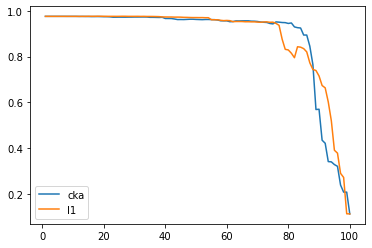

In [33]:
import matplotlib.pyplot as plt
tensor = lambda x: x
cka_prune = [tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9757), tensor(0.9757), tensor(0.9757), tensor(0.9757), tensor(0.9754), tensor(0.9755), tensor(0.9753), tensor(0.9752), tensor(0.9748), tensor(0.9749), tensor(0.9750), tensor(0.9747), tensor(0.9743), tensor(0.9743), tensor(0.9737), tensor(0.9721), tensor(0.9722), tensor(0.9724), tensor(0.9724), tensor(0.9723), tensor(0.9725), tensor(0.9726), tensor(0.9729), tensor(0.9729), tensor(0.9730), tensor(0.9731), tensor(0.9729), tensor(0.9716), tensor(0.9716), tensor(0.9713), tensor(0.9710), tensor(0.9717), tensor(0.9665), tensor(0.9665), tensor(0.9663), tensor(0.9642), tensor(0.9618), tensor(0.9620), tensor(0.9618), tensor(0.9625), tensor(0.9633), tensor(0.9633), tensor(0.9624), tensor(0.9619), tensor(0.9614), tensor(0.9621), tensor(0.9622), tensor(0.9617), tensor(0.9614), tensor(0.9599), tensor(0.9565), tensor(0.9562), tensor(0.9562), tensor(0.9525), tensor(0.9531), tensor(0.9560), tensor(0.9558), tensor(0.9563), tensor(0.9563), tensor(0.9563), tensor(0.9548), tensor(0.9546), tensor(0.9534), tensor(0.9511), tensor(0.9500), tensor(0.9492), tensor(0.9448), tensor(0.9429), tensor(0.9516), tensor(0.9505), tensor(0.9489), tensor(0.9484), tensor(0.9449), tensor(0.9470), tensor(0.9298), tensor(0.9264), tensor(0.9250), tensor(0.8943), tensor(0.8942), tensor(0.8456), tensor(0.7653), tensor(0.5692), tensor(0.5704), tensor(0.4352), tensor(0.4219), tensor(0.3419), tensor(0.3407), tensor(0.3289), tensor(0.3213), tensor(0.2394), tensor(0.2086), tensor(0.2086), tensor(0.1135)]
l1_prune = [tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9757), tensor(0.9758), tensor(0.9758), tensor(0.9761), tensor(0.9761), tensor(0.9761), tensor(0.9763), tensor(0.9763), tensor(0.9761), tensor(0.9759), tensor(0.9759), tensor(0.9759), tensor(0.9758), tensor(0.9759), tensor(0.9762), tensor(0.9761), tensor(0.9758), tensor(0.9758), tensor(0.9758), tensor(0.9759), tensor(0.9756), tensor(0.9758), tensor(0.9754), tensor(0.9754), tensor(0.9753), tensor(0.9750), tensor(0.9746), tensor(0.9733), tensor(0.9731), tensor(0.9729), tensor(0.9729), tensor(0.9724), tensor(0.9725), tensor(0.9723), tensor(0.9715), tensor(0.9713), tensor(0.9708), tensor(0.9705), tensor(0.9705), tensor(0.9703), tensor(0.9704), tensor(0.9699), tensor(0.9699), tensor(0.9610), tensor(0.9609), tensor(0.9608), tensor(0.9585), tensor(0.9572), tensor(0.9580), tensor(0.9570), tensor(0.9527), tensor(0.9533), tensor(0.9533), tensor(0.9532), tensor(0.9522), tensor(0.9523), tensor(0.9518), tensor(0.9518), tensor(0.9508), tensor(0.9500), tensor(0.9514), tensor(0.9518), tensor(0.9499), tensor(0.9504), tensor(0.9451), tensor(0.9366), tensor(0.8762), tensor(0.8319), tensor(0.8292), tensor(0.8149), tensor(0.7953), tensor(0.8431), tensor(0.8413), tensor(0.8350), tensor(0.8207), tensor(0.7731), tensor(0.7440), tensor(0.7394), tensor(0.7156), tensor(0.6739), tensor(0.6638), tensor(0.6022), tensor(0.5201), tensor(0.3914), tensor(0.3788), tensor(0.2906), tensor(0.2727), tensor(0.1141), tensor(0.1135)]

plt.plot(list(range(1, 101)), cka_prune, label="cka")
plt.plot(list(range(1, 101)), l1_prune, label="l1")
plt.legend()
plt.show()